<img align="left" src="logouniandes.png" alt="drawing" width="400"/>

<p align="rigth">  Proyecto 3 Machine Learning 
    
<p align="rigth"> Nombre: Thomas Grange
    
<p align="rigth">  Código: 202015791 </p>

### Introducción

Vamos a implementar diferentes algoritmos de RL, desde uno de los controles más simples de gym : CartPole.
Se monta una vara en un carro, el carro se mueve y la vara se mueve en secuencia. El juego se gana si la vara se mantiene en equilibrio. Así que jugaremos con el ángulo entre la vertical y la barra. (El derivado de este ángulo también puede ser útil).
El carruaje puede moverse a la derecha, a la izquierda.

Para ello utilizaremos stable baselines

En primer lugar, para presentar el problema, aquí hay un video de este cartucho con un random agent: las decisiones se toman al azar. Como en este juego, pierdes tan pronto como la vara pasa de un cierto ángulo, el juego se detiene y se reinicia muy rápidamente.

In [1]:
import gym
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = 'CartPole-v1'
video_folder = ''
video_length = 100

env = DummyVecEnv([lambda: gym.make(env_id)])

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix="random-agent-{}".format(env_id))

env.reset()
for _ in range(video_length + 1):
  action = [env.action_space.sample()]
  obs, _, _, _ = env.step(action)
# Save the video
env.close()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Saving video to  /home/grangeth/Bureau/Machine_Learning/random-agent-CartPole-v1-step-0-to-step-100.mp4


<img src="RA.png" width="300">
     CartPole con Random agent, haz clic en el siguiente enlace : 
     
  [Random_agent (enlace youtube)](https://youtu.be/bgJ2He3fads)


In [2]:
#Importando bibliotecas de stable baselines para implementar los modelos/algoritmos

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.policies import MlpPolicy as Mlp2
from stable_baselines import DQN
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy

from stable_baselines.common.callbacks import BaseCallback
from stable_baselines import PPO2


Voy a usar los siguientes algoritmos :

* DQN
La situación consiste en un agente, un conjunto de estados s  y acciones a. Al realizar una acción a en A, el agente va de un estado a otro y recibe una recompensa. El objetivo del agente es maximizar su recompensa total. Esto se logra aprendiendo la acción óptima para cada estado. La acción óptima para cada estado corresponde a la que tiene la mayor recompensa a largo plazo. Esta recompensa es una suma ponderada de la expectativa matemática de las recompensas de cada paso futuro del estado actual. El algoritmo resultante mas sencillo es le DQN, lo cual vamos a usar.

* PPO2
El algoritmo de Optimización de Política Proximal combina ideas de A2C (que tiene múltiples trabajadores) y TRPO (que utiliza una región de confianza para mejorar el actor). La idea principal es que después de una actualización, la nueva política no debe estar muy lejos de la antigua política. Para ello, la OPC utiliza el recorte para evitar una actualización demasiado grande. Usaré este último porque es un algoritmo "avanzado" para este ejercicio.

El código que figura a continuación fue tomado directamente de un notebook [1], permite tener un acceso de retrollamada al modelo durante el entrenamiento, y así poder graficarlo.

In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True
    
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

A continuación, el entrenamiento de los dos algoritmos con los hiperparámetros por defecto:

In [4]:
import os
from stable_baselines.bench import Monitor
# og dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Crear entorno
env = gym.make('CartPole-v1')
env = Monitor(env, log_dir)
env2 = make_vec_env('CartPole-v1', n_envs=1, monitor_dir=log_dir+"monitor")

# Callbakc cada 1000 pasos
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

callback2 = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir+"monitor")

modeldqnt = DQN(MlpPolicy, env, verbose=1)
modelppo2 = PPO2(Mlp2, env2, verbose = 1)

# entrenamiento del modelo
modeldqnt.learn(total_timesteps=50000, callback = callback)
modelppo2.learn(total_timesteps=50000, callback = callback2)
modeldqnt.save("deepq_cartpole")
modelppo2.save("deepppo2_cartpole")








Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 21.70
Saving new best model to /tmp/gym/best_model
Num timesteps: 2000
Best mean reward: 21.70 - Last mean reward per episode: 21.59
--------------------------------------
| % time spent exploring  | 58       |
| episodes                | 100      |
| mean 100 episode reward | 21.6     |
| steps                   | 2141     |
--------------------------------------
Num timesteps: 3000
Best mean reward: 21.70 - Last mean reward per episode: 25.51
Saving new best model to /tmp/gym/best_model
Num timesteps: 4000
Best mean reward: 25.51 - Last mean reward per episode: 32.09
Saving new best model to /tmp/gym/best_model
Num timesteps: 5000
Best mean reward: 32.09 - Last mean rewa

Num timesteps: 27000
Best mean reward: 112.22 - Last mean reward per episode: 115.29
Saving new best model to /tmp/gym/best_model
Num timesteps: 28000
Best mean reward: 115.29 - Last mean reward per episode: 116.36
Saving new best model to /tmp/gym/best_model
Num timesteps: 29000
Best mean reward: 116.36 - Last mean reward per episode: 116.06
Num timesteps: 30000
Best mean reward: 116.36 - Last mean reward per episode: 116.27
Num timesteps: 31000
Best mean reward: 116.36 - Last mean reward per episode: 115.85
Num timesteps: 32000
Best mean reward: 116.36 - Last mean reward per episode: 116.61
Saving new best model to /tmp/gym/best_model
Num timesteps: 33000
Best mean reward: 116.61 - Last mean reward per episode: 117.33
Saving new best model to /tmp/gym/best_model
Num timesteps: 34000
Best mean reward: 117.33 - Last mean reward per episode: 118.07
Saving new best model to /tmp/gym/best_model
--------------------------------------
| % time spent exploring  | 2        |
| episodes       

--------------------------------------
| approxkl           | 2.7284028e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 27.7          |
| ep_reward_mean     | 27.7          |
| explained_variance | 0.00812       |
| fps                | 709           |
| n_updates          | 10            |
| policy_entropy     | 0.67495       |
| policy_loss        | 0.00025485142 |
| serial_timesteps   | 1280          |
| time_elapsed       | 2             |
| total_timesteps    | 1280          |
| value_loss         | 47.421055     |
--------------------------------------
---------------------------------------
| approxkl           | 1.15784915e-05 |
| clipfrac           | 0.0            |
| ep_len_mean        | 27.5           |
| ep_reward_mean     | 27.5           |
| explained_variance | -0.0367        |
| fps                | 748            |
| n_updates          | 11             |
| policy_entropy     | 0.6756624      |
| policy_loss        | -0.00016203569 |
| serial_timest

Num timesteps: 3000
Best mean reward: 26.97 - Last mean reward per episode: 30.33
Saving new best model to /tmp/gym/monitor/best_model
--------------------------------------
| approxkl           | 0.00018719949 |
| clipfrac           | 0.0           |
| ep_len_mean        | 30.8          |
| ep_reward_mean     | 30.8          |
| explained_variance | 0.0373        |
| fps                | 682           |
| n_updates          | 24            |
| policy_entropy     | 0.6448728     |
| policy_loss        | -0.0005555956 |
| serial_timesteps   | 3072          |
| time_elapsed       | 4.47          |
| total_timesteps    | 3072          |
| value_loss         | 61.042084     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0003598329 |
| clipfrac           | 0.0          |
| ep_len_mean        | 30.8         |
| ep_reward_mean     | 30.8         |
| explained_variance | 0.118        |
| fps                | 711          |
| n_updates   

---------------------------------------
| approxkl           | 1.4067577e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 43.7           |
| ep_reward_mean     | 43.7           |
| explained_variance | 0.016          |
| fps                | 755            |
| n_updates          | 38             |
| policy_entropy     | 0.60533303     |
| policy_loss        | -0.00067621004 |
| serial_timesteps   | 4864           |
| time_elapsed       | 6.93           |
| total_timesteps    | 4864           |
| value_loss         | 45.84479       |
---------------------------------------
--------------------------------------
| approxkl           | 4.0173454e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 44.8          |
| ep_reward_mean     | 44.8          |
| explained_variance | 0.146         |
| fps                | 754           |
| n_updates          | 39            |
| policy_entropy     | 0.6294913     |
| policy_loss        | -0.0007890997 |
| serial_t

--------------------------------------
| approxkl           | 0.00022446192 |
| clipfrac           | 0.0           |
| ep_len_mean        | 56.6          |
| ep_reward_mean     | 56.6          |
| explained_variance | 0.0756        |
| fps                | 736           |
| n_updates          | 52            |
| policy_entropy     | 0.6347305     |
| policy_loss        | -0.0033303804 |
| serial_timesteps   | 6656          |
| time_elapsed       | 9.39          |
| total_timesteps    | 6656          |
| value_loss         | 59.66977      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00020668411 |
| clipfrac           | 0.0           |
| ep_len_mean        | 56.6          |
| ep_reward_mean     | 56.6          |
| explained_variance | -0.0497       |
| fps                | 771           |
| n_updates          | 53            |
| policy_entropy     | 0.6131593     |
| policy_loss        | 0.0003646597  |
| serial_timesteps   | 67

--------------------------------------
| approxkl           | 5.2727605e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 69.8          |
| ep_reward_mean     | 69.8          |
| explained_variance | -0.0148       |
| fps                | 796           |
| n_updates          | 66            |
| policy_entropy     | 0.6222039     |
| policy_loss        | 4.5530847e-05 |
| serial_timesteps   | 8448          |
| time_elapsed       | 11.8          |
| total_timesteps    | 8448          |
| value_loss         | 67.80147      |
--------------------------------------
---------------------------------------
| approxkl           | 4.65844e-06    |
| clipfrac           | 0.0            |
| ep_len_mean        | 71             |
| ep_reward_mean     | 71             |
| explained_variance | 0.0399         |
| fps                | 748            |
| n_updates          | 67             |
| policy_entropy     | 0.59617054     |
| policy_loss        | -0.00027001183 |
| serial_timest

---------------------------------------
| approxkl           | 0.000114174836 |
| clipfrac           | 0.0            |
| ep_len_mean        | 85.2           |
| ep_reward_mean     | 85.2           |
| explained_variance | 0.0597         |
| fps                | 707            |
| n_updates          | 80             |
| policy_entropy     | 0.60637814     |
| policy_loss        | 0.002778995    |
| serial_timesteps   | 10240          |
| time_elapsed       | 14.2           |
| total_timesteps    | 10240          |
| value_loss         | 56.205017      |
---------------------------------------
---------------------------------------
| approxkl           | 5.448317e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 85.2           |
| ep_reward_mean     | 85.2           |
| explained_variance | 0.095          |
| fps                | 726            |
| n_updates          | 81             |
| policy_entropy     | 0.62479866     |
| policy_loss        | -0.00050716754 |


Num timesteps: 12000
Best mean reward: 91.29 - Last mean reward per episode: 100.29
Saving new best model to /tmp/gym/monitor/best_model
--------------------------------------
| approxkl           | 5.128314e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 100           |
| ep_reward_mean     | 100           |
| explained_variance | 0.297         |
| fps                | 687           |
| n_updates          | 94            |
| policy_entropy     | 0.6043881     |
| policy_loss        | -0.0037257588 |
| serial_timesteps   | 12032         |
| time_elapsed       | 16.8          |
| total_timesteps    | 12032         |
| value_loss         | 45.324112     |
--------------------------------------
--------------------------------------
| approxkl           | 5.589132e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 101           |
| ep_reward_mean     | 101           |
| explained_variance | 0.248         |
| fps                | 617           |
| n_u

--------------------------------------
| approxkl           | 1.5146403e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 114           |
| ep_reward_mean     | 114           |
| explained_variance | 0.00365       |
| fps                | 747           |
| n_updates          | 108           |
| policy_entropy     | 0.60800105    |
| policy_loss        | -0.0008296834 |
| serial_timesteps   | 13824         |
| time_elapsed       | 19.3          |
| total_timesteps    | 13824         |
| value_loss         | 61.24411      |
--------------------------------------
--------------------------------------
| approxkl           | 6.775528e-06  |
| clipfrac           | 0.0           |
| ep_len_mean        | 114           |
| ep_reward_mean     | 114           |
| explained_variance | 0.00236       |
| fps                | 728           |
| n_updates          | 109           |
| policy_entropy     | 0.62987065    |
| policy_loss        | 0.00010989094 |
| serial_timesteps   | 13

--------------------------------------
| approxkl           | 4.1290463e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 128           |
| ep_reward_mean     | 128           |
| explained_variance | 0.414         |
| fps                | 736           |
| n_updates          | 122           |
| policy_entropy     | 0.6039509     |
| policy_loss        | 0.0026570794  |
| serial_timesteps   | 15616         |
| time_elapsed       | 21.8          |
| total_timesteps    | 15616         |
| value_loss         | 54.373047     |
--------------------------------------
---------------------------------------
| approxkl           | 7.2571133e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 129            |
| ep_reward_mean     | 129            |
| explained_variance | 0.546          |
| fps                | 713            |
| n_updates          | 123            |
| policy_entropy     | 0.6129571      |
| policy_loss        | -0.00010870921 |
| serial_timest

--------------------------------------
| approxkl           | 0.00041142752 |
| clipfrac           | 0.0           |
| ep_len_mean        | 136           |
| ep_reward_mean     | 136           |
| explained_variance | 0.102         |
| fps                | 764           |
| n_updates          | 136           |
| policy_entropy     | 0.60465455    |
| policy_loss        | -0.0037790025 |
| serial_timesteps   | 17408         |
| time_elapsed       | 24.2          |
| total_timesteps    | 17408         |
| value_loss         | 56.81061      |
--------------------------------------
---------------------------------------
| approxkl           | 7.681052e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 137            |
| ep_reward_mean     | 137            |
| explained_variance | 0.143          |
| fps                | 779            |
| n_updates          | 137            |
| policy_entropy     | 0.5965239      |
| policy_loss        | -0.00096413284 |
| serial_timest

--------------------------------------
| approxkl           | 0.00032050247 |
| clipfrac           | 0.0           |
| ep_len_mean        | 145           |
| ep_reward_mean     | 145           |
| explained_variance | 0.0275        |
| fps                | 659           |
| n_updates          | 150           |
| policy_entropy     | 0.56539816    |
| policy_loss        | -0.0012562072 |
| serial_timesteps   | 19200         |
| time_elapsed       | 26.8          |
| total_timesteps    | 19200         |
| value_loss         | 59.59974      |
--------------------------------------
---------------------------------------
| approxkl           | 2.1372718e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 145            |
| ep_reward_mean     | 145            |
| explained_variance | 0.0287         |
| fps                | 468            |
| n_updates          | 151            |
| policy_entropy     | 0.5899489      |
| policy_loss        | -0.00036896858 |
| serial_timest

--------------------------------------
| approxkl           | 7.3601615e-07 |
| clipfrac           | 0.0           |
| ep_len_mean        | 155           |
| ep_reward_mean     | 155           |
| explained_variance | 0.0116        |
| fps                | 779           |
| n_updates          | 164           |
| policy_entropy     | 0.55652887    |
| policy_loss        | 8.856808e-05  |
| serial_timesteps   | 20992         |
| time_elapsed       | 30.1          |
| total_timesteps    | 20992         |
| value_loss         | 37.19019      |
--------------------------------------
Num timesteps: 21000
Best mean reward: 150.47 - Last mean reward per episode: 154.62
Saving new best model to /tmp/gym/monitor/best_model
--------------------------------------
| approxkl           | 0.00015255353 |
| clipfrac           | 0.0           |
| ep_len_mean        | 157           |
| ep_reward_mean     | 157           |
| explained_variance | 0.896         |
| fps                | 609           |
| n_

-------------------------------------
| approxkl           | 0.0027761874 |
| clipfrac           | 0.0078125    |
| ep_len_mean        | 169          |
| ep_reward_mean     | 169          |
| explained_variance | 0.873        |
| fps                | 697          |
| n_updates          | 178          |
| policy_entropy     | 0.5826863    |
| policy_loss        | -0.005500934 |
| serial_timesteps   | 22784        |
| time_elapsed       | 32.6         |
| total_timesteps    | 22784        |
| value_loss         | 20.102325    |
-------------------------------------
---------------------------------------
| approxkl           | 0.000118872566 |
| clipfrac           | 0.0            |
| ep_len_mean        | 168            |
| ep_reward_mean     | 168            |
| explained_variance | 0.00689        |
| fps                | 692            |
| n_updates          | 179            |
| policy_entropy     | 0.56219584     |
| policy_loss        | -0.0020630714  |
| serial_timesteps   | 22912  

--------------------------------------
| approxkl           | 0.0013702577  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 177           |
| ep_reward_mean     | 177           |
| explained_variance | 0.91          |
| fps                | 389           |
| n_updates          | 192           |
| policy_entropy     | 0.5817121     |
| policy_loss        | -0.0015775946 |
| serial_timesteps   | 24576         |
| time_elapsed       | 35.7          |
| total_timesteps    | 24576         |
| value_loss         | 12.088384     |
--------------------------------------
--------------------------------------
| approxkl           | 3.490188e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 177           |
| ep_reward_mean     | 177           |
| explained_variance | 0.533         |
| fps                | 544           |
| n_updates          | 193           |
| policy_entropy     | 0.55739343    |
| policy_loss        | 0.00025615457 |
| serial_timesteps   | 24

--------------------------------------
| approxkl           | 0.00018312738 |
| clipfrac           | 0.0           |
| ep_len_mean        | 187           |
| ep_reward_mean     | 187           |
| explained_variance | 0.0948        |
| fps                | 673           |
| n_updates          | 206           |
| policy_entropy     | 0.5596781     |
| policy_loss        | 0.0025861643  |
| serial_timesteps   | 26368         |
| time_elapsed       | 38.5          |
| total_timesteps    | 26368         |
| value_loss         | 79.38461      |
--------------------------------------
---------------------------------------
| approxkl           | 3.955501e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 187            |
| ep_reward_mean     | 187            |
| explained_variance | 0.865          |
| fps                | 737            |
| n_updates          | 207            |
| policy_entropy     | 0.57194906     |
| policy_loss        | -0.00011953316 |
| serial_timest

--------------------------------------
| approxkl           | 0.00081001513 |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | 197           |
| explained_variance | 0.969         |
| fps                | 600           |
| n_updates          | 220           |
| policy_entropy     | 0.54777       |
| policy_loss        | 0.0049906326  |
| serial_timesteps   | 28160         |
| time_elapsed       | 41.2          |
| total_timesteps    | 28160         |
| value_loss         | 14.988513     |
--------------------------------------
--------------------------------------
| approxkl           | 7.447863e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 197           |
| ep_reward_mean     | 197           |
| explained_variance | 0.503         |
| fps                | 637           |
| n_updates          | 221           |
| policy_entropy     | 0.5424233     |
| policy_loss        | -0.0019518558 |
| serial_timesteps   | 28

--------------------------------------
| approxkl           | 4.5426282e-07 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | 203           |
| explained_variance | 0.946         |
| fps                | 705           |
| n_updates          | 234           |
| policy_entropy     | 0.58146995    |
| policy_loss        | 4.0710438e-07 |
| serial_timesteps   | 29952         |
| time_elapsed       | 43.8          |
| total_timesteps    | 29952         |
| value_loss         | 19.015528     |
--------------------------------------
Num timesteps: 30000
Best mean reward: 202.55 - Last mean reward per episode: 203.37
Saving new best model to /tmp/gym/monitor/best_model
--------------------------------------
| approxkl           | 7.5475866e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 203           |
| ep_reward_mean     | 203           |
| explained_variance | 0.91          |
| fps                | 580           |
| n_

--------------------------------------
| approxkl           | 2.589615e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 207           |
| ep_reward_mean     | 207           |
| explained_variance | 0.79          |
| fps                | 773           |
| n_updates          | 248           |
| policy_entropy     | 0.56221384    |
| policy_loss        | -0.0017068288 |
| serial_timesteps   | 31744         |
| time_elapsed       | 46.5          |
| total_timesteps    | 31744         |
| value_loss         | 24.633972     |
--------------------------------------
--------------------------------------
| approxkl           | 7.134124e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 207           |
| ep_reward_mean     | 207           |
| explained_variance | 0.946         |
| fps                | 785           |
| n_updates          | 249           |
| policy_entropy     | 0.57402694    |
| policy_loss        | -0.0006677271 |
| serial_timesteps   | 31

--------------------------------------
| approxkl           | 1.7118124e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 214           |
| ep_reward_mean     | 214           |
| explained_variance | 0.0537        |
| fps                | 708           |
| n_updates          | 262           |
| policy_entropy     | 0.5521821     |
| policy_loss        | 0.00084645883 |
| serial_timesteps   | 33536         |
| time_elapsed       | 49            |
| total_timesteps    | 33536         |
| value_loss         | 108.570175    |
--------------------------------------
--------------------------------------
| approxkl           | 6.0423406e-07 |
| clipfrac           | 0.0           |
| ep_len_mean        | 214           |
| ep_reward_mean     | 214           |
| explained_variance | 0.282         |
| fps                | 642           |
| n_updates          | 263           |
| policy_entropy     | 0.5532194     |
| policy_loss        | 3.619655e-05  |
| serial_timesteps   | 33

--------------------------------------
| approxkl           | 2.6742588e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 221           |
| ep_reward_mean     | 221           |
| explained_variance | 0.0759        |
| fps                | 611           |
| n_updates          | 276           |
| policy_entropy     | 0.56154436    |
| policy_loss        | 0.00014360063 |
| serial_timesteps   | 35328         |
| time_elapsed       | 52.4          |
| total_timesteps    | 35328         |
| value_loss         | 115.18782     |
--------------------------------------
--------------------------------------
| approxkl           | 1.0061731e-06 |
| clipfrac           | 0.0           |
| ep_len_mean        | 221           |
| ep_reward_mean     | 221           |
| explained_variance | -0.0659       |
| fps                | 442           |
| n_updates          | 277           |
| policy_entropy     | 0.57667774    |
| policy_loss        | 2.3377012e-05 |
| serial_timesteps   | 35

Num timesteps: 37000
Best mean reward: 223.43 - Last mean reward per episode: 231.44
Saving new best model to /tmp/gym/monitor/best_model
----------------------------------------
| approxkl           | 5.956828e-06    |
| clipfrac           | 0.0             |
| ep_len_mean        | 231             |
| ep_reward_mean     | 231             |
| explained_variance | 0.103           |
| fps                | 570             |
| n_updates          | 290             |
| policy_entropy     | 0.5772942       |
| policy_loss        | -0.000100255944 |
| serial_timesteps   | 37120           |
| time_elapsed       | 55.1            |
| total_timesteps    | 37120           |
| value_loss         | 13.0697         |
----------------------------------------
--------------------------------------
| approxkl           | 0.0006190369  |
| clipfrac           | 0.0           |
| ep_len_mean        | 232           |
| ep_reward_mean     | 232           |
| explained_variance | 0.00103       |
| fps        

--------------------------------------
| approxkl           | 0.00035549694 |
| clipfrac           | 0.0           |
| ep_len_mean        | 237           |
| ep_reward_mean     | 237           |
| explained_variance | 0.0267        |
| fps                | 657           |
| n_updates          | 304           |
| policy_entropy     | 0.588934      |
| policy_loss        | -0.0005411868 |
| serial_timesteps   | 38912         |
| time_elapsed       | 57.7          |
| total_timesteps    | 38912         |
| value_loss         | 11.252231     |
--------------------------------------
Num timesteps: 39000
Best mean reward: 234.48 - Last mean reward per episode: 237.00
Saving new best model to /tmp/gym/monitor/best_model
--------------------------------------
| approxkl           | 0.00018864017 |
| clipfrac           | 0.0           |
| ep_len_mean        | 237           |
| ep_reward_mean     | 237           |
| explained_variance | -0.197        |
| fps                | 663           |
| n_

--------------------------------------
| approxkl           | 0.00020117172 |
| clipfrac           | 0.0           |
| ep_len_mean        | 248           |
| ep_reward_mean     | 248           |
| explained_variance | -1.19         |
| fps                | 751           |
| n_updates          | 318           |
| policy_entropy     | 0.5825184     |
| policy_loss        | 0.0006395597  |
| serial_timesteps   | 40704         |
| time_elapsed       | 60.5          |
| total_timesteps    | 40704         |
| value_loss         | 10.8105135    |
--------------------------------------
--------------------------------------
| approxkl           | 1.8999763e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 251           |
| ep_reward_mean     | 251           |
| explained_variance | 0.0448        |
| fps                | 674           |
| n_updates          | 319           |
| policy_entropy     | 0.58325475    |
| policy_loss        | 1.0544085e-05 |
| serial_timesteps   | 40

-------------------------------------
| approxkl           | 4.427674e-05 |
| clipfrac           | 0.0          |
| ep_len_mean        | 257          |
| ep_reward_mean     | 257          |
| explained_variance | -0.492       |
| fps                | 792          |
| n_updates          | 332          |
| policy_entropy     | 0.5332819    |
| policy_loss        | 0.0008906146 |
| serial_timesteps   | 42496        |
| time_elapsed       | 63.2         |
| total_timesteps    | 42496        |
| value_loss         | 9.154519     |
-------------------------------------
--------------------------------------
| approxkl           | 0.00018548577 |
| clipfrac           | 0.0           |
| ep_len_mean        | 257           |
| ep_reward_mean     | 257           |
| explained_variance | 0.39          |
| fps                | 794           |
| n_updates          | 333           |
| policy_entropy     | 0.54673386    |
| policy_loss        | -0.0004615506 |
| serial_timesteps   | 42624         |
|

--------------------------------------
| approxkl           | 0.00087250397 |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 266           |
| ep_reward_mean     | 266           |
| explained_variance | 0.282         |
| fps                | 723           |
| n_updates          | 346           |
| policy_entropy     | 0.5328076     |
| policy_loss        | -0.0011908342 |
| serial_timesteps   | 44288         |
| time_elapsed       | 65.8          |
| total_timesteps    | 44288         |
| value_loss         | 127.94496     |
--------------------------------------
--------------------------------------
| approxkl           | 6.113427e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 266           |
| ep_reward_mean     | 266           |
| explained_variance | 0.273         |
| fps                | 698           |
| n_updates          | 347           |
| policy_entropy     | 0.55837846    |
| policy_loss        | -0.0002762403 |
| serial_timesteps   | 44

Num timesteps: 46000
Best mean reward: 267.32 - Last mean reward per episode: 271.49
Saving new best model to /tmp/gym/monitor/best_model
---------------------------------------
| approxkl           | 0.00088174397  |
| clipfrac           | 0.0            |
| ep_len_mean        | 271            |
| ep_reward_mean     | 271            |
| explained_variance | -0.0818        |
| fps                | 674            |
| n_updates          | 360            |
| policy_entropy     | 0.5578598      |
| policy_loss        | -0.00047930912 |
| serial_timesteps   | 46080          |
| time_elapsed       | 68.4           |
| total_timesteps    | 46080          |
| value_loss         | 6.711586       |
---------------------------------------
--------------------------------------
| approxkl           | 0.0002939935  |
| clipfrac           | 0.0           |
| ep_len_mean        | 273           |
| ep_reward_mean     | 273           |
| explained_variance | 0.00053       |
| fps                | 724  

---------------------------------------
| approxkl           | 1.6333045e-06  |
| clipfrac           | 0.0            |
| ep_len_mean        | 278            |
| ep_reward_mean     | 278            |
| explained_variance | 0.00072        |
| fps                | 694            |
| n_updates          | 374            |
| policy_entropy     | 0.51867795     |
| policy_loss        | -2.3937318e-05 |
| serial_timesteps   | 47872          |
| time_elapsed       | 71             |
| total_timesteps    | 47872          |
| value_loss         | 5.78965        |
---------------------------------------
Num timesteps: 48000
Best mean reward: 273.83 - Last mean reward per episode: 277.90
Saving new best model to /tmp/gym/monitor/best_model
---------------------------------------
| approxkl           | 5.343767e-06   |
| clipfrac           | 0.0            |
| ep_len_mean        | 278            |
| ep_reward_mean     | 278            |
| explained_variance | 0.783          |
| fps                |

--------------------------------------
| approxkl           | 0.00041857737 |
| clipfrac           | 0.0           |
| ep_len_mean        | 292           |
| ep_reward_mean     | 292           |
| explained_variance | -0.00907      |
| fps                | 712           |
| n_updates          | 388           |
| policy_entropy     | 0.48895964    |
| policy_loss        | -0.0010298425 |
| serial_timesteps   | 49664         |
| time_elapsed       | 73.6          |
| total_timesteps    | 49664         |
| value_loss         | 192.90633     |
--------------------------------------
--------------------------------------
| approxkl           | 7.60051e-07   |
| clipfrac           | 0.0           |
| ep_len_mean        | 292           |
| ep_reward_mean     | 292           |
| explained_variance | -0.632        |
| fps                | 674           |
| n_updates          | 389           |
| policy_entropy     | 0.49952435    |
| policy_loss        | 2.3713219e-05 |
| serial_timesteps   | 49

Ahora vamos a hacer un gráfico del entrenamiento

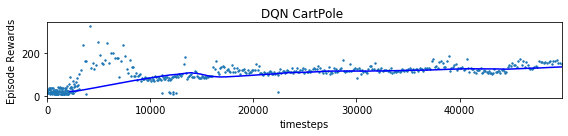

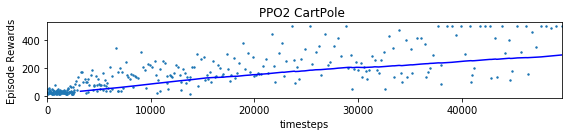

In [5]:
from stable_baselines import results_plotter
# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DQN CartPole ")
results_plotter.plot_results([log_dir+"monitor"], 1e5, results_plotter.X_TIMESTEPS, "PPO2 CartPole ")

Como era de esperar, el algoritmo de dqn, si es más constante, obtiene una durabilidad media muy inferior a la de ppo2. (180 para el dqn, 240 para el ppo2). Además, la ppo2 parece estar en constante aumento. Para visualizar esto, voy a grabar dos videos de test para cada model entrenado, los cuáles estarán disponibles en youtube.

In [11]:
envv = DummyVecEnv([lambda: gym.make(env_id)])

obs = envv.reset()

# Record the video starting at the first step
envv = VecVideoRecorder(envv, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length + 200,
                       name_prefix="post_entrenamiento_dqn-{}".format(env_id))

envv.reset()
for _ in range(video_length + 201):
  action, _state  =modeldqnt.predict(obs)
  obs, rewards, dones, info = envv.step(action)
# Save the video
envv.close()

Saving video to  /home/grangeth/Bureau/Machine_Learning/post_entrenamiento_dqn-CartPole-v1-step-0-to-step-300.mp4


El resultado es obviamente mucho mejor que con un agente aleatorio, el bastón se mantiene en equilibrio unos 4 segundos antes de caer.

Para el video, haz clic en el siguiente enlace:

[Video_post_entrenamiento_DQN](https://youtu.be/lEAcObUGZ4k)

In [10]:
envp = DummyVecEnv([lambda: gym.make(env_id)])

obs = envp.reset()

# Record the video starting at the first step
envp = VecVideoRecorder(envp, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length + 200,
                       name_prefix="post_entrenamiento_ppo2-{}".format(env_id))

envp.reset()
for _ in range(video_length + 201):
  action, _state  =modelppo2.predict(obs)
  obs, rewards, dones, info = envp.step(action)
# Save the video
envp.close()

Saving video to  /home/grangeth/Bureau/Machine_Learning/post_entrenamiento_ppo2-CartPole-v1-step-0-to-step-300.mp4


Los resultados son de hecho mejores para la ppo2, el palo no cae de los 6 segundos de los videos, y parece estable.

Para el video, haz clic en el siguiente enlace:

[Video_post_entrenamiento_PPO2](https://youtu.be/k0c5aHqMex8)

Como el dqn tuvo los peores resultados, ahora intentaremos mejorar su rendimiento actuando directamente sobre los parámetros de entrenamiento. 
Vamos a influir sobre dos parametros en particular : LR y Gamma.

* Tasa de aprendizaje: lr o tasa de aprendizaje, a menudo denominada alfa o α, puede definirse simplemente como cuánto aceptas el nuevo valor frente al antiguo. Arriba estamos tomando la diferencia entre el nuevo y el viejo y luego multiplicando ese valor por la tasa de aprendizaje. Este valor se añade entonces a nuestro anterior valor q, que esencialmente lo mueve en la dirección de nuestra última actualización.

* Gamma: gamma o γ es un factor de descuento. Se utiliza para equilibrar la recompensa inmediata y futura. De nuestra regla de actualización anterior puede ver que aplicamos el descuento a la recompensa futura. Típicamente este valor puede variar entre 0.8 y 0.99.

Según la documentación de la línea de base estable, los ajustes por defecto son: gamma=0.99, learning_rate=0.0005

Para "suavizar" el aprendizaje, intentaré reducir el gamma, disminuyendo el impacto de las recompensas en los tiros que siguen inmediatamente después, pero aumentando la tasa de aprendizaje. De esta manera los cambios serán más lentos, pero más seguros, en teoría. Así que voy a intentarlo con un gamma = 0,85 y lr = 0,001.

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 23.65
Saving new best model to /tmp/gym/best_model
Num timesteps: 2000
Best mean reward: 23.65 - Last mean reward per episode: 24.87
Saving new best model to /tmp/gym/best_model
--------------------------------------
| % time spent exploring  | 45       |
| episodes                | 100      |
| mean 100 episode reward | 28.1     |
| steps                   | 2780     |
--------------------------------------
Num timesteps: 3000
Best mean reward: 24.87 - Last mean reward per episode: 28.63
Saving new best model to /tmp/gym/best_model
Num timesteps: 4000
Best mean reward: 28.63 - Last mean reward per episode: 34.52
Saving new best model to /tmp/gym/best_model
Num timesteps: 5000
Best mean reward: 34.52 - Last mean reward per episode: 41.65
Saving new best model to /tmp/gym/best_model
Num timesteps: 6000
Best mean reward: 41.65 - Last mean reward per episode: 48.88
Saving new best model to /tmp/gym/best_model
Num t

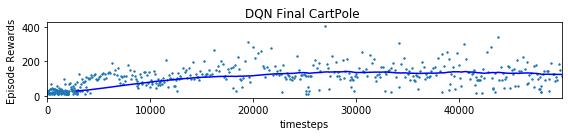

In [14]:
# Crear entorno
envf = gym.make('CartPole-v1')
envf = Monitor(env, log_dir+"final")


# Callbakc cada 1000 pasos
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

modeldqntf = DQN(MlpPolicy,envf,gamma= 0.85,learning_rate = 0.001,  verbose=1)


# entrenamiento del modelo
modeldqntf.learn(total_timesteps=50000, callback = callback)

results_plotter.plot_results([log_dir+"final"], 1e5, results_plotter.X_TIMESTEPS, "DQN Final CartPole ")

El proceso de aprendizaje es, en efecto, más suave y constante, sin embargo, sigue siendo más bajo que con los parámetros por defecto. La tendencia general, en los diferentes estudios que se han hecho, es que, a menos que se haya hecho una optimización general variando estos parámetros a lo largo de muchas iteraciones, es difícil hacerlo mejor que los parámetros básicos.

In [15]:
envt = DummyVecEnv([lambda: gym.make(env_id)])

obs = envt.reset()

# Record the video starting at the first step
envt = VecVideoRecorder(envt, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length + 200,
                       name_prefix="post_entrenamiento_final_dqn-{}".format(env_id))

envt.reset()
for _ in range(video_length + 201):
  action, _state  =modeldqntf.predict(obs)
  obs, rewards, dones, info = envt.step(action)
# Save the video
envt.close()

Saving video to  /home/grangeth/Bureau/Machine_Learning/post_entrenamiento_final_dqn-CartPole-v1-step-0-to-step-300.mp4


Esto confirma el gráfico obtenido anteriormente, en 7 segundos, el carro se pone en marcha de nuevo 4 veces, lo que es un resultado mucho menos bueno que con los parámetros básicos.

Para el video, haz clic en el siguiente enlace:

[Video_post_entrenamiento_final](https://youtu.be/qODcFGyEyZw)

### Referencias

* Gym openAI: https://gym.openai.com/
* Documentacion stable baselines: https://stable-baselines.readthedocs.io/en/master/index.html
* Fernando Lozano, Aprendizaje por refuerzo
* Hyperparameter Optimization for Deep Reinforcement Learning in Vehicle Energy Management, Roman Liessner, Jakob Schmitt, Enero 2019
* Simple Reinforcement Learning: Q-learning, Andre Violante: https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
*  [1] Stable Baselines, a Fork of OpenAI Baselines - Monitor Training and Plotting: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/monitor_training.ipynb#scrollTo=iaOPfOrwWEP4
